<a href="https://colab.research.google.com/github/Arshad221b/MedSeg/blob/main/second_ty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random 
import torch 
from torch.utils import data 
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image

In [2]:
! pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import nibabel as nib

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Collection

In [5]:
# ! unzip /content/drive/MyDrive/AMOS/amos22.zip

# Data Loader

In [6]:
IMAGE_SIZE = 32
BATCH_SIZE = 2
NUM_CLASS = 15

In [7]:
import cv2
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [8]:
class AmosDataLoader(data.Dataset):
  def __init__(
      self, 
      input_paths: list, 
      target_paths: list, 
      transform_input = None, 
      transform_target = None
  ): 

    self.input_paths      = input_paths
    self.target_paths     = target_paths
    self.transform_input  = transform_input
    self.transform_target = transform_target

  def __len__(self):
    return len(self.input_paths)

  def preprocess_img_input(self, input_im):
    # z_factor_input      = input_im.shape[2]*int(input_im.shape[0]/IMAGE_SIZE)**2
    input_im            = np.stack((input_im,)*3, axis=-1)
    input_im            = torch.tensor(input_im).float()/255
    # print(input_im.shape)
    input_im            = input_im.permute(3,2,0,1)
    
    input_im            = input_im.unsqueeze(0)
    # print('input_shape before inter',input_im.shape)
    output_size_input   = (82, IMAGE_SIZE, IMAGE_SIZE)
    input_im            = F.interpolate(input_im, size=output_size_input, mode='trilinear', align_corners=False)
    input_im            = input_im#.squeeze(0)
    return input_im

  def preprocess_output(self, output_im):
    # z_factor_output      = output_im.shape[2]*int(output_im.shape[0]/IMAGE_SIZE)**2
    # output_im            = torch.tensor(output_im).float()/255
    # print('output shape before mask', output_im.shape)
    mask_cat              = np.zeros((NUM_CLASS, *output_im.shape), dtype=np.float32)
    for i in range(NUM_CLASS):
        mask_cat[i][output_im == i] = 1
    # output_im = torch.tensor(mask_cat).float()
    output_im             = torch.tensor(mask_cat).float()/255
    # print(output_im.shape)
    output_im             = output_im.permute(0,2,3,1)
    # print(output_im.shape)
    output_im             = output_im.unsqueeze(0)#.unsqueeze(0)
    # print('output shape befor inter',output_im.shape)
    output_size_input     = (82, IMAGE_SIZE, IMAGE_SIZE)
    output_im             = F.interpolate(output_im, size=output_size_input, mode='trilinear', align_corners=False)
    output_im             = output_im#.squeeze(0)
    
    
    # print('output shape final', output_im.shape)
    return output_im

  def __getitem__(self,x):
    input_image   = self.input_paths[x]
    target_image  = self.target_paths[x]
    input_im      = nib.load(input_image).get_fdata()
    target_im     = nib.load(target_image).get_fdata()

    return input_im, target_im
    
  def collate_fn(self, batch):
    # print(len(batch[0][0]))
    im_ins, im_outs = [], []
    for im_in, im_out  in batch: 
      im_in = self.preprocess_img_input(im_in)
      im_out = self.preprocess_output(im_out)
      # print(im_in.shape, im_out.shape)
      im_ins.append(im_in)
      im_outs.append(im_out)

    # print(torch.tensor(im_ins).shape)
    return torch.cat(im_ins, dim = 0).to(device), torch.cat(im_outs, dim= 0).to(device)

In [9]:
path = '/content/amos22/'


input_paths   = sorted(glob(os.path.join(path, "imagesVa","*.nii.gz")))
target_paths  = sorted(glob(os.path.join(path, "labelsVa","*.nii.gz")))

In [10]:
train_dl      = AmosDataLoader(input_paths, target_paths)
train_loader  = DataLoader(train_dl, batch_size = BATCH_SIZE, drop_last= True, collate_fn=train_dl.collate_fn)

In [11]:
for d,k in train_dl: 
  # # print(len(d))}
  print(d.shape, k.shape)
  break

(768, 768, 101) (768, 768, 101)


In [12]:
# def preprocess_output( output_im):
#     z_factor_output      = output_im.shape[2]*int(output_im.shape[0]/IMAGE_SIZE)**2
#     # output_im            = torch.tensor(output_im).float()/255
#     mask_cat              = np.zeros((NUM_CLASS, *output_im.shape), dtype=np.float32)
#     for i in range(NUM_CLASS):
#         mask_cat[i][output_im == i] = 1

#     output_im             = torch.tensor(mask_cat).float()/255
#     output_im             = output_im.permute(3,2,0,1)
#     # print(output_im.shape)
#     output_im             = output_im.unsqueeze(0)
#     output_size_input     = (15, IMAGE_SIZE, IMAGE_SIZE)
#     output_im             = F.interpolate(output_im, size=output_size_input, mode='trilinear', align_corners=False)
#     output_im             = output_im#.squeeze(0)
#     return output_im

In [13]:
# import torchvision.transforms.functional as TF 
# target_image = target_paths[0]
# mask_nii     = nib.load(target_image)
# mask_data = mask_nii.get_fdata()

# o = preprocess_output(mask_data)
# # target_im  = torch.tensor(target_im)

# num_classes = 15

# # Convert the mask to categorical values
# mask_cat = np.zeros((num_classes, *mask_data.shape), dtype=np.float32)
# for i in range(num_classes):
#     mask_cat[i][mask_data == i] = 1

# # Save the categorical mask as a new NIfTI image
# mask_cat_nii = nib.Nifti1Image(mask_cat, mask_nii.affine, mask_nii.header)
# # nib.save(mask_cat_nii, "mask_cat.nii.gz")

In [14]:
# o.shape

In [15]:
o = 0
mask_data = 0
mask_nii = 0 


In [16]:
# mask_cat.shape

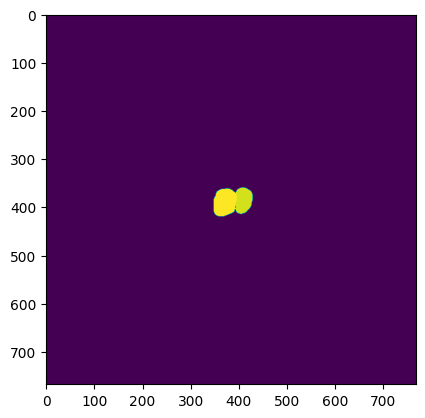

In [17]:
import nibabel as nib

test_load = nib.load('/content/amos22/labelsVa/amos_0008.nii.gz').get_fdata()
test = test_load[:,:,21]
plt.imshow(test)
plt.show()

In [18]:
# for i, j in train_dl: 
#   print(i.shape, j.shape)
#   i = i.permute(2,1,0)
#   plt.imshow(i[:,:,59].unsqeeze(0).to('cpu'))
#   plt.show()N
#   # print(i)
#   break

In [19]:
# import torch.nn.functional as F

# # Assume tensor of shape (batch_size, channels, depth, height, width)
# x = torch.randn(1, 1, 90, 768, 768)

# # Specify the output size of the tensor after interpolation
# output_size = (810,  256, 256)

# # Interpolate the tensor to the desired output size using trilinear interpolation
# y = F.interpolate(x, size=output_size, mode='trilinear', align_corners=False)

# # The shape of the resulting tensor should be (batch_size, channels, depth, height, width)
# print(y.shape)

In [20]:
# a,b = next(iter(train_loader))
# a.shape, b.shape

In [21]:
input_paths

['/content/amos22/imagesVa/amos_0008.nii.gz',
 '/content/amos22/imagesVa/amos_0013.nii.gz',
 '/content/amos22/imagesVa/amos_0018.nii.gz',
 '/content/amos22/imagesVa/amos_0022.nii.gz',
 '/content/amos22/imagesVa/amos_0029.nii.gz',
 '/content/amos22/imagesVa/amos_0032.nii.gz']

# Model Building


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Down3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv3D(in_channels, out_channels)
        )

    def forward(self, x):
        return self.mpconv(x)

class Up3D(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels, in_channels//2, kernel_size=2, stride=2)

        self.conv = DoubleConv3D(in_channels, out_channels)

    def forward(self, x1, x2):
        # print(x1.shape, x2.shape)
        x1    = self.up(x1)
        # print(x1.shape)
        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1    = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2,
                        diffZ // 2, diffZ - diffZ // 2))
        x     = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv3D, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, 1)

    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.bilinear     = bilinear

        self.conv1    = DoubleConv3D(in_channels, 64)
        self.down1    = Down3D(64, 128)
        self.down2    = Down3D(128, 256)
        self.down3    = Down3D(256, 512)
        self.down4    = Down3D(512, 1024)
        self.up1      = Up3D(1024, 512, bilinear)
        self.up2      = Up3D(512, 256, bilinear)
        self.up3      = Up3D(256, 128, bilinear)
        self.up4      = Up3D(128, 64, bilinear)
        self.outconv  = OutConv3D(64, out_channels)

    def forward(self, x):
        # print(x.shape)
        # x = x.unsqueeze(1)
        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        # print(x5.shape, x4.shape)
        x6 = self.up1(x5, x4)
        x7 = self.up2(x6, x3)
        x8 = self.up3(x7, x2) 
        x9 = self.up4(x8, x1)
        output= self.outconv(x9)
        # print(x6.shape)
        # up network

        return output



In [23]:
model = UNet3D(3, 15).to(device)

# Model Train

In [24]:
# im= torch.zeros((2, 3,82,128,128))
# UNet3D(3,15).forward(im)

In [25]:

# !pip install torchsummary
# from torchsummary import summary
# summary(model, input_size=(3, 82, 128, 128), device=device)

In [26]:
def train_batch(data, model, optimizer, criteria):
    model.train()
    
    ims_in, ims_out = data
    # print(ims_in.shape)
    optimizer.zero_grad()
    # print(ims_in.shape)
    pred_img = model(ims_in)    
    print(pred_img.shape)
    # gender_criterion, age_criterion = criteria
    # gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    # age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = criteria(pred_img, ims_out)
    total_loss.backward()
    optimizer.step()
    return total_loss

# def validate_batch(data, model, criteria):
#     model.eval()
#     ims, age, gender = data
#     with torch.no_grad():
#       pred_gender, pred_age = model(ims)
#     gender_criterion, age_criterion = criteria
#     gender_loss = gender_criterion(pred_gender.squeeze(), gender)
#     age_loss = age_criterion(pred_age.squeeze(), age)
#     total_loss = gender_loss + age_loss
#     pred_gender = (pred_gender > 0.5).squeeze()
#     gender_acc = (pred_gender == gender).float().sum()
#     age_mae = torch.abs(age - pred_age).float().sum()
#     return total_loss, gender_acc, age_mae

In [27]:
n_epoch = 2
criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
for epoch in range(n_epoch):
  print(epoch)
  epoch_loss = []

  for ix, ims in enumerate(train_loader):
    loss = train_batch(ims, model, optimizer, criteria)
    epoch_loss.append(loss)
  print('avg_loss', sum(epoch_loss)/len(epoch_loss))


0
torch.Size([2, 15, 82, 32, 32])
